In [17]:
from pickletools import uint8
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from MNISTManager import MNISTManager
from operator import itemgetter
from terminaltables import AsciiTable


> _Import each matrices in a dictionnary like this :_
* trainingImages : 60000 training 28*28 images
* trainingLabels : 60000 labels for each training images
* testingImages : 10000 testing 28*28 images
* testingLabels : 10000 labels for each testing images

In [18]:
from MNISTManager import MNISTManager

matrices = MNISTManager(
    os.path.abspath('') + "/../datasets/train-images-idx3-ubyte.gz",
    os.path.abspath('') + "/../datasets/train-labels-idx1-ubyte.gz",
    os.path.abspath('') + "/../datasets/t10k-images-idx3-ubyte.gz",
    os.path.abspath('') + "/../datasets/t10k-labels-idx1-ubyte.gz",
).getMatrices()

> _Define utilitaries functions_

In [19]:
def getEuclidianDistance(x, y): return np.sqrt(np.sum(x - y)**2) #get the euclidian distance between 2 matrices

def getKNearestNeighbors(k, sortedDistances): #given a value of k and a sorteed distances list, returns the k neirest neighbors in an new list
    kDistances = sortedDistances[:k]
    return [x[1] for x in kDistances]

def getAccuraryPercentage(predictedLabels, realLabels): #get the acccuracy of the given labels list compared to the training labels
    accuracy = 0
    for i in range(len(predictedLabels)):
        if realLabels[i] == predictedLabels[i]:
            accuracy += 1
    return (accuracy / len(predictedLabels) * 100)

def printProgression(x):
    print(f"\t{x}%", end='\r')
    sys.stdout.flush()

>_Define the getKNearestCorrespondingLabels function_

In [20]:
def getKNearestCorrespondingLabels(k, imageDataset, labelDataset, kValuesData=None): #kValuesData = tuple(kIndex, kValuesLength)
    correspondingLabels = []
    batchSize = len(imageDataset)
    for i in range(batchSize):
        distances = []
        printProgression(
            f"\t{ round(   ((kValuesData[0] / kValuesData[1] * 100) + ( (i / batchSize) ) / kValuesData[1] * 100 ), 5   ) }%"
            if kValuesData != None
            else f"\t{round( (i / batchSize) * 100, 5 )}%",
        )
        for j in range(len(imageDataset)):
            distances.append( ( getEuclidianDistance(imageDataset[i], imageDataset[j]), labelDataset[j] ) )
        distances.sort(key = lambda x : x[0])
        kNearestNeighbors = getKNearestNeighbors(k, distances)
        correspondingLabels.append( max( kNearestNeighbors, key=kNearestNeighbors.count ) ) #for each image, we add the most propable neigbor for the current value of k    
    return correspondingLabels


>_KNN algorithm to get the best value of K_

In [21]:
def train(batchSize = 600): #returns K
    kValues = [(3, 0),(5, 0), (7, 0), (9, 0)]  #[(kNeigbors, accuracyPercentage)] possible k values
    for kIndex in range(len(kValues)):
        correspondingLabels = getKNearestCorrespondingLabels(
            kValues[kIndex][0], matrices['trainingImages'][:batchSize],
            matrices['trainingLabels'][:batchSize],
            (kIndex, len(kValues))
        )
        kValues[kIndex] = (kValues[kIndex][0], getAccuraryPercentage(correspondingLabels, matrices['trainingLabels'][:batchSize]))
    #print a basic table of k stats
    kValuesTable = AsciiTable(
        [
            ["K"] + [x[0] for x in kValues],
            ["Accuracy"] + [str( round( x[1] , 3 ) ) + "%" for x in kValues]
        ]
    )
    print(kValuesTable.table)
    return max(kValues, key=itemgetter(1))[0] # we keep only the best accuracy of each k values

k = train(600)
print(f"K value is : {k}")

+----------+-------+---------+-------+---------+
| K        | 3     | 5       | 7     | 9       |
+----------+-------+---------+-------+---------+
| Accuracy | 86.0% | 66.167% | 53.5% | 49.833% |
+----------+-------+---------+-------+---------+
K value is : 3


> _We store the predicted values using the testing set and the k value_

In [22]:
from numpy import append

testingBatchSize = 500

def getPredictedValues(k, batchSize = 100): #we set a limit to limit time process
    predictedValues = []
    for i in range(batchSize):
        distances = []
        printProgression( round( (i / batchSize) * 100, 5 ))
        for j in range(batchSize):
            distances.append( (  getEuclidianDistance(matrices['testingImages'][i], matrices['testingImages'][j]) , matrices['testingLabels'][j]) )
            distances.sort(key = lambda x : x[0]) #sort by distance
        kNearestNeighbors = getKNearestNeighbors(k, distances)
        predictedValues.append(max( kNearestNeighbors, key=kNearestNeighbors.count ))
    return predictedValues

predictedValues = getPredictedValues(k, testingBatchSize)



>_Plot the confusion matrix_

Accuracy : 86.8%


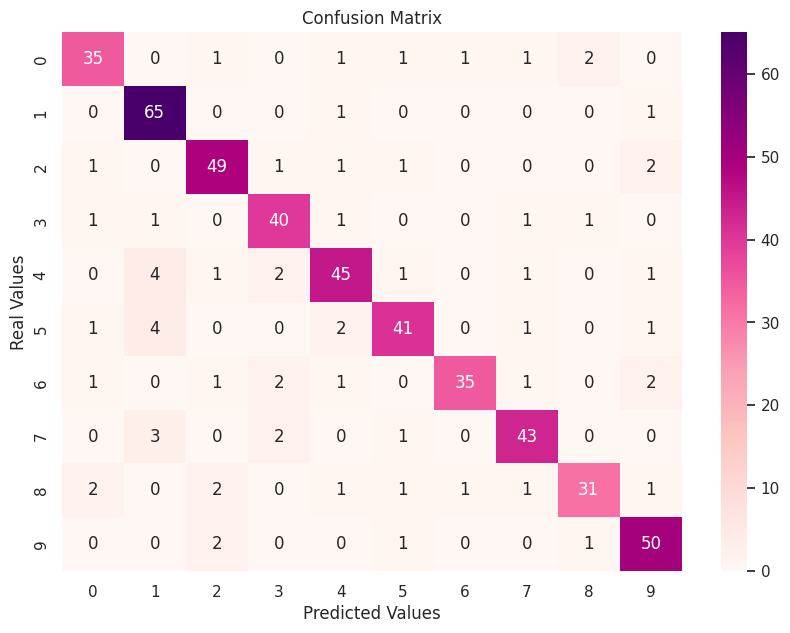

In [83]:
from sklearn import metrics
import seaborn as sn

def plotConfusionMatrix(realValues, predictedValues):
    cm = metrics.confusion_matrix(realValues, predictedValues)
    plt.figure(figsize=(10, 7))    
    plt.title("Confusion Matrix")
    snHeatmap = sn.heatmap(cm, annot=True, cmap='RdPu')
    snHeatmap.set(xlabel='Predicted Values', ylabel='Real Values')

plotConfusionMatrix(matrices['testingLabels'][:testingBatchSize].tolist(), predictedValues)
print(f"Accuracy : {getAccuraryPercentage(predictedValues, matrices['testingLabels'][:testingBatchSize])}%")